Total DOID nodes: 14493
Total DOID edges: 109070


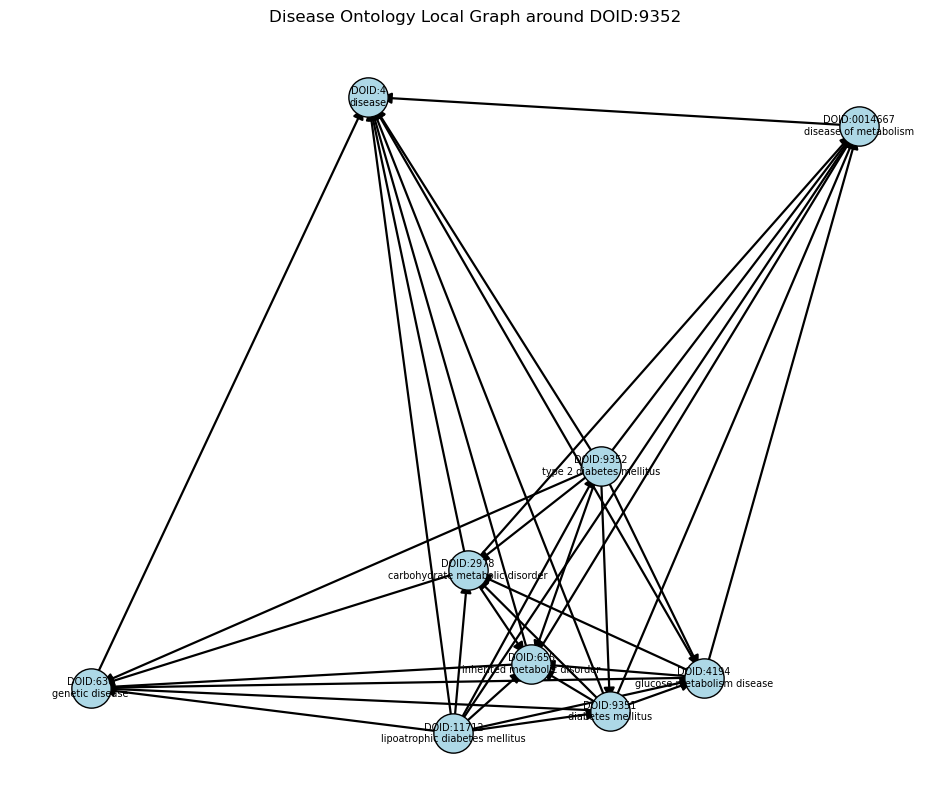

In [ ]:
#局部可视化obo子图,以某一点的前后邻居节点展示

import pronto
import networkx as nx
import matplotlib.pyplot as plt

# Load ontology
ontology = pronto.Ontology("/data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.obo")

# Build graph with only DOID:* nodes
G = nx.DiGraph()

for term in ontology.terms():
    if not term.id.startswith("DOID"):
        continue

    # store both id and name as attributes
    G.add_node(term.id, label=term.name)

    for parent in term.superclasses(with_self=False):
        if parent.id.startswith("DOID"):
            G.add_edge(term.id, parent.id, pred="is_a")

print("Total DOID nodes:", len(G))
print("Total DOID edges:", len(G.edges()))

# ----------- visualize local subgraph -------------
CENTER = "DOID:9352"   # e.g. "diabetes mellitus"

neighbors = set([CENTER])
neighbors.update(G.predecessors(CENTER))  # parents
neighbors.update(G.successors(CENTER))    # children

H = G.subgraph(neighbors)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, k=0.4, iterations=50)

nx.draw_networkx_nodes(H, pos, node_size=800, node_color="lightblue", edgecolors="black")
# Draw directed edges with clearer arrow style
nx.draw_networkx_edges(
    H, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=16,
    # connectionstyle='arc3,rad=0.05',
    width=1.6
)

labels = {n: f"{n}\n{H.nodes[n]['label']}" for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=7)

plt.title(f"Disease Ontology Local Graph around {CENTER}")
plt.axis("off")
plt.show()


Nodes: 14493
Edges: 109070


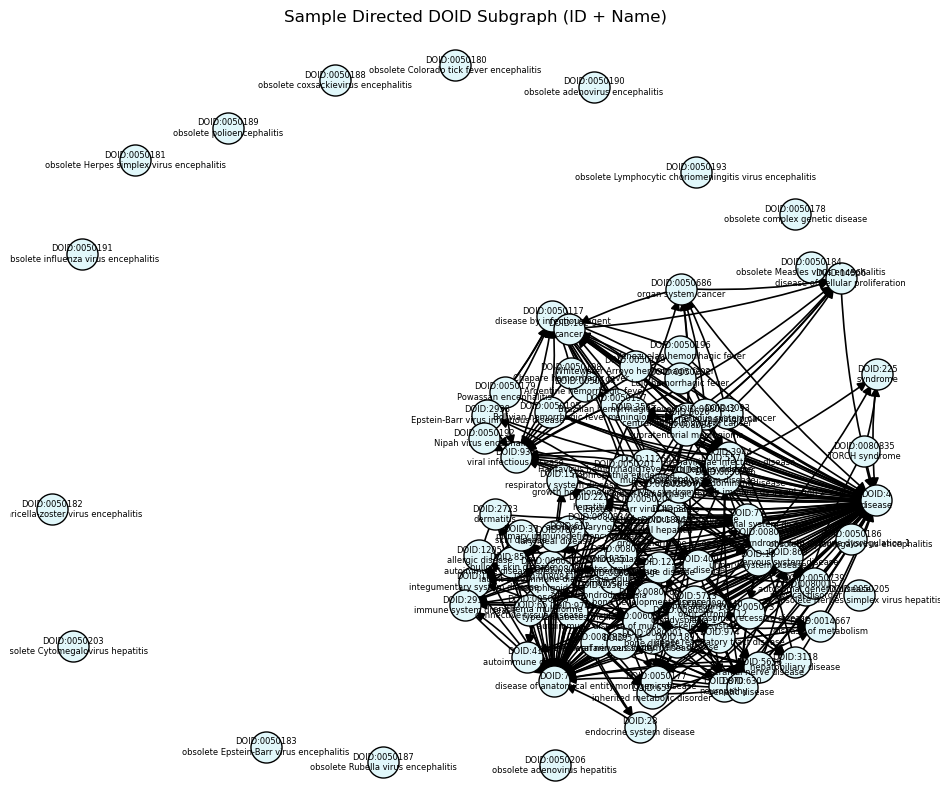

In [ ]:
# 局部可视化obo子图,以随机节点的前后邻居节点展示

import pronto
import networkx as nx
import matplotlib.pyplot as plt

ontology = pronto.Ontology("/data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.obo")

G = nx.DiGraph()

for term in ontology.terms():
    G.add_node(term.id, label=term.name)
    for parent in term.superclasses(with_self=False):
        if parent.id.startswith("DOID"):
            G.add_edge(term.id, parent.id, pred="is_a")

print("Nodes:", len(G.nodes()))
print("Edges:", len(G.edges()))

# visualize a sample
sub = list(G.nodes())[:100]
H = G.subgraph(sub)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, k=0.7, iterations=80)

nx.draw_networkx_nodes(H, pos, node_size=500, node_color="#e0f7fa", edgecolors="black")

nx.draw_networkx_edges(
    H, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=14,
    connectionstyle='arc3,rad=0.06',
    width=1.2
)

labels = {n: f"{n}\n{H.nodes[n]['label']}" for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=6)

plt.title("Sample Directed DOID Subgraph (ID + Name)")
plt.axis("off")
plt.show()


In [ ]:
"""
读取obo格式数据，并转换为适合LLM训练的JSONL格式
Parse a DOID OWL file with pronto and export per-term JSON lines usable for LLM prompts.
"""

import json
from pronto import Ontology
from pathlib import Path
from typing import List, Dict, Any

INPUT_PATH = "/data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.owl"  # change to doid.owl or doid-base.owl if you prefer
OUTPUT_PATH = "doid_terms.jsonl"

def get_term_parents(term) -> List[str]:
    """
    Best-effort extract of direct parents (asserted is_a).
    Pronto exposes 'superclasses(distance=1)' which returns parents (if available).
    Fallback: inspect relations for 'is_a' style relations.
    """
    parents = set()

    # Method 1: try superclasses(distance=1)
    try:
        for p in term.superclasses(distance=1):
            # superclasses yields Term objects (may include self) — ensure not self
            if p.id != term.id:
                parents.add(p.id)
    except Exception:
        pass

    # Method 2: use relations mapping (pronto stores relations in term.relations)
    try:
        rels = getattr(term, "relations", None)
        if rels:
            # relations is a dict: {Relation: set(Term)}
            for rel, targets in rels.items():
                # prefer rdfs:subClassOf / is_a-like relations; check rel.id or rel.name
                rid = getattr(rel, "id", None) or str(rel)
                if rid and ("is_a" in str(rid).lower() or "subclass" in str(rid).lower() or "subclassof" in str(rid).lower()):
                    for t in targets:
                        parents.add(getattr(t, "id", str(t)))
    except Exception:
        pass

    return sorted(parents)

def get_term_equivalents(term) -> List[str]:
    """
    Try to collect equivalentClass expressions or logical definitions.
    Pronto exposes 'equivalent_to' on Term (best-effort).
    """
    eqs = []
    try:
        eqs_attr = getattr(term, "equivalent_to", None)
        if eqs_attr:
            for expr in eqs_attr:
                # expression may be an object; stringify it
                eqs.append(str(expr))
    except Exception:
        pass
    return eqs

def extract_term_info(term) -> Dict[str, Any]:
    info = {
        "id": term.id,
        "name": getattr(term, "name", None),
        "definition": None,
        "synonyms": [],
        "xrefs": [],
        "parents": [],
        "equivalent_expressions": [],
        "annotations": {}
    }

    # definition
    try:
        # pronto: term.definition is a string or Definition object
        d = getattr(term, "definition", None)
        if d:
            # sometimes it's a Definition object with .description
            desc = getattr(d, "description", None)
            info["definition"] = desc if desc is not None else str(d)
    except Exception:
        pass

    # synonyms
    try:
        syns = getattr(term, "synonyms", None)
        if syns:
            for s in syns:
                # Synonym object typically has .desc and .scope
                desc = getattr(s, "desc", None) or str(s)
                scope = getattr(s, "scope", None)
                info["synonyms"].append({"text": desc, "scope": str(scope) if scope else None})
    except Exception:
        pass

    # xrefs / annotations
    try:
        xrefs = getattr(term, "xrefs", None)
        if xrefs:
            info["xrefs"] = [str(x) for x in xrefs]
    except Exception:
        pass

    # parents
    info["parents"] = get_term_parents(term)

    # equivalent expressions / logical definitions
    info["equivalent_expressions"] = get_term_equivalents(term)

    # arbitrary annotations (labels, comments, etc.)
    try:
        for k, vs in getattr(term, "annotations", {}).items():
            # k may be an IRI or object — coerce to str
            info["annotations"][str(k)] = [str(v) for v in vs]
    except Exception:
        pass

    return info

def main():
    p = Path(INPUT_PATH)
    if not p.exists():
        raise FileNotFoundError(f"Input file not found: {p.resolve()}")

    print(f"Loading ontology from: {p} (this may take a while for merged files)...")
    ont = Ontology(str(p))

    print(f"Ontology loaded. Terms count (including root/obsolete): {len(list(ont.terms()))}")
    outf = open(OUTPUT_PATH, "w", encoding="utf-8")

    count = 0
    for term in ont.terms():
        # skip metadata or anonymous nodes if you want:
        # if term.obsolete: continue
        # if term.id.startswith("owl:") or term.id.startswith("rdf:"): continue

        info = extract_term_info(term)
        outf.write(json.dumps(info, ensure_ascii=False) + "\n")
        count += 1
        if count % 500 == 0:
            print(f"Processed {count} terms...")

    outf.close()
    print(f"Done. Wrote {count} term records to {OUTPUT_PATH}")

main()

Loading ontology from: /data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.owl (this may take a while for merged files)...


/data/kunfeng/miniconda3/envs/ontology/lib/python3.13/site-packages/pronto/ontology.py:291: NotImplementedWarning: cannot process plain `owl:AnnotationProperty`
  cls(self).parse_from(_handle)  # type: ignore
/data/kunfeng/miniconda3/envs/ontology/lib/python3.13/site-packages/pronto/ontology.py:291: SyntaxWarning: could not find axiom source: 'IAO:0000115'
  cls(self).parse_from(_handle)  # type: ignore
/data/kunfeng/miniconda3/envs/ontology/lib/python3.13/site-packages/pronto/ontology.py:291: SyntaxWarning: could not find axiom source: 'http://purl.org/dc/elements/1.1/description'
  cls(self).parse_from(_handle)  # type: ignore
/data/kunfeng/miniconda3/envs/ontology/lib/python3.13/site-packages/pronto/ontology.py:291: SyntaxWarning: could not find axiom source: 'http://purl.org/dc/elements/1.1/title'
  cls(self).parse_from(_handle)  # type: ignore
/data/kunfeng/miniconda3/envs/ontology/lib/python3.13/site-packages/pronto/ontology.py:291: SyntaxWarning: could not find axiom source: 'ht

Ontology loaded. Terms count (including root/obsolete): 19304
Processed 500 terms...
Processed 1000 terms...
Processed 1500 terms...
Processed 2000 terms...
Processed 2500 terms...
Processed 3000 terms...
Processed 3500 terms...
Processed 4000 terms...
Processed 4500 terms...
Processed 5000 terms...
Processed 5500 terms...
Processed 6000 terms...
Processed 6500 terms...
Processed 7000 terms...
Processed 7500 terms...
Processed 8000 terms...
Processed 8500 terms...
Processed 9000 terms...
Processed 9500 terms...
Processed 10000 terms...
Processed 10500 terms...
Processed 11000 terms...
Processed 11500 terms...
Processed 12000 terms...
Processed 12500 terms...
Processed 13000 terms...
Processed 13500 terms...
Processed 14000 terms...
Processed 14500 terms...
Processed 15000 terms...
Processed 15500 terms...
Processed 16000 terms...
Processed 16500 terms...
Processed 17000 terms...
Processed 17500 terms...
Processed 18000 terms...
Processed 18500 terms...
Processed 19000 terms...
Done. Wr

In [ ]:
# 统计 DOID 叶子节点和分组节点数量

import pronto

obo_path = "/data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.obo"
ont = pronto.Ontology(obo_path)

grouping = []
leaf_diseases = []

for t in ont.terms():
    # 排除非 DOID
    if not t.id.startswith("DOID"):
        continue
    # 排除 obsolete
    if getattr(t, "obsolete", False):
        continue
    
    # 获取子类（不包含自身）
    children = list(t.subclasses(with_self=False))
    
    if len(children) > 0:
        # 有子类 => grouping class
        grouping.append({
            "id": t.id,
            "name": t.name,
            "num_children": len(children)
        })
    else:
        # 没有子类 => leaf disease（真正疾病类）
        leaf_diseases.append({
            "id": t.id,
            "name": t.name
        })

print("Total non-obsolete DOID terms:", len(grouping) + len(leaf_diseases))
print("Grouping classes:", len(grouping))
print("Leaf-level disease classes:", len(leaf_diseases))

# optional: inspect first few
print("\nExample grouping classes:")
for g in grouping[:20]:
    print(g)


Total non-obsolete DOID terms: 11985
Grouping classes: 2428
Leaf-level disease classes: 9557

Example grouping classes:
{'id': 'DOID:0001816', 'name': 'angiosarcoma', 'num_children': 9}
{'id': 'DOID:0002116', 'name': 'pterygium', 'num_children': 4}
{'id': 'DOID:0014667', 'name': 'disease of metabolism', 'num_children': 882}
{'id': 'DOID:0040001', 'name': 'shrimp allergy', 'num_children': 4}
{'id': 'DOID:0040021', 'name': 'cephalosporin allergy', 'num_children': 7}
{'id': 'DOID:0080841', 'name': 'pemphigoid', 'num_children': 3}
{'id': 'DOID:0080854', 'name': 'anaplastic pleomorphic xanthoastrocytoma', 'num_children': 1}
{'id': 'DOID:0080855', 'name': 'Parkinsonism', 'num_children': 1}
{'id': 'DOID:0080875', 'name': 'IDH-mutant anaplastic astrocytoma', 'num_children': 3}
{'id': 'DOID:0080879', 'name': 'histone mutated tumor', 'num_children': 2}
{'id': 'DOID:0080882', 'name': 'IDH-mutant and 1p/19q-codeleted oligodendroglioma', 'num_children': 2}
{'id': 'DOID:0080883', 'name': 'vitamin D-

In [ ]:
# 分类统计缺少定义(definition)的 DOID 术语:
# 1) 名称以 'obsolete' 开头 (疑似废弃) 且无定义
# 2) 正常名称但无定义
# 输出统计与覆盖率并分别保存 CSV

#25年新增和24年新增都作为测试集

import pronto
import pandas as pd
from pathlib import Path

obo_path = Path('/data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.obo')
if not obo_path.exists():
    raise FileNotFoundError(f'找不到 OBO 文件: {obo_path}')

total_doid = 0
obsolete_missing = []
normal_missing = []

ont = pronto.Ontology(str(obo_path))  # 如果环境提示未导出, 仍然按 pronto 常规用法尝试; 若失败可改为: from pronto import Ontology; ont = Ontology(str(obo))
total = 0
obsolete_missing = []
normal_missing = []

for t in ont.terms():
    tid = getattr(t, 'id', '')
    if not tid.startswith('DOID'):
        continue
    total += 1
    d = getattr(t, 'definition', None)
    # 提取定义文本
    if d:
        desc = getattr(d, 'description', None) if hasattr(d, 'description') else str(d)
        if desc and str(desc).strip():
            continue  # 有定义跳过
    name_val = (getattr(t, 'name', '') or '').strip()
    entry = {'id': tid, 'name': name_val, 'definition': None}
    if name_val.lower().startswith('obsolete'):
        obsolete_missing.append(entry)
    else:
        normal_missing.append(entry)

missing_total = len(obsolete_missing) + len(normal_missing)
coverage_all = 0.0 if total == 0 else 100.0 * (total - missing_total) / total
total_ex_obsolete = total - len(obsolete_missing)
coverage_ex_obsolete = 0.0 if total_ex_obsolete == 0 else 100.0 * (total_ex_obsolete - len(normal_missing)) / total_ex_obsolete

print('===== Summary =====')
print(f'Total DOID terms: {total}')
print(f'Missing total: {missing_total}')
print(f'Missing obsolete-name: {len(obsolete_missing)}')
print(f'Missing normal: {len(normal_missing)}')
print(f'Definition coverage (all): {coverage_all:.2f}%')
print(f'Coverage excluding obsolete group: {coverage_ex_obsolete:.2f}%')

df_obsolete = pd.DataFrame(obsolete_missing).sort_values('id')
df_normal = pd.DataFrame(normal_missing).sort_values('id')
# df_all = pd.concat([df_obsolete, df_normal], ignore_index=True).sort_values('id')

print('\n前20条 obsolete 缺定义:')
print(df_obsolete.head(20))
print('\n前20条 正常缺定义:')
print(df_normal.head(20))

df_obsolete.to_csv('doid_obsolete_missing_definitions.csv', index=False, encoding='utf-8')
df_normal.to_csv('doid_normal_missing_definitions.csv', index=False, encoding='utf-8')
# df_all.to_csv('doid_all_missing_definitions.csv', index=False, encoding='utf-8')
print('文件已保存: doid_obsolete_missing_definitions.csv, doid_normal_missing_definitions.csv')


In [ ]:
# 对比不同版本中非 obsolete DOID 的 definition/term 变化

from IPython.display import clear_output; clear_output(wait=False)
import pandas as pd
import pronto
from pathlib import Path

VERSION_PATHS = {
    "2023-12-20": Path("/data/kunfeng/datasets/HumanDiseaseOntology-2023-12-20/src/ontology/doid.obo"),
    "2024-12-18": Path("/data/kunfeng/datasets/HumanDiseaseOntology-2024-12-18/src/ontology/doid.obo"),
    "2025-10-31": Path("/data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.obo"),
}

for label, path in VERSION_PATHS.items():
    if not path.exists():
        raise FileNotFoundError(f"找不到 {label} 的 OBO 文件: {path}")


def clean_definition(raw_def):
    """将 pronto 的 Definition 对象规整成去除空白的字符串。"""
    if not raw_def:
        return None
    desc = getattr(raw_def, "description", None)
    text = (desc if desc is not None else str(raw_def)).strip()
    return text or None


def load_terms(obo_path: Path) -> dict:
    """返回 {term_id: {name, definition}}（仅保留非 obsolete DOID）。"""
    print(f"加载本体: {obo_path} ...")
    ontology = pronto.Ontology(str(obo_path))
    collected = {}
    for term in ontology.terms():
        tid = getattr(term, "id", "")
        if not tid.startswith("DOID") or getattr(term, "obsolete", False): # pronto.Term 的确自带一个布尔属性 obsolete，等效于 obo json 中的 deprecated 字段
            continue
        collected[tid] = {
            "name": getattr(term, "name", None),
            "definition": clean_definition(getattr(term, "definition", None)),
        }
    print(f"{obo_path.name}: 非 obsolete DOID 数量 = {len(collected)}")
    return collected


def definition_additions(old_terms: dict, new_terms: dict) -> pd.DataFrame:
    rows = []
    for tid in sorted(set(old_terms) & set(new_terms)):
        if not old_terms[tid]["definition"] and new_terms[tid]["definition"]:
            rows.append({
                "id": tid,
                "name": new_terms[tid]["name"],
                "definition": new_terms[tid]["definition"],
            })
    return pd.DataFrame(rows)


def brand_new_terms(old_terms: dict, new_terms: dict) -> pd.DataFrame:
    rows = []
    for tid in sorted(set(new_terms) - set(old_terms)):
        rows.append({
            "id": tid,
            "name": new_terms[tid]["name"], # pronto模拟OBO format语义，名称即 term name，对应obo json中的lbl字段
            "definition": new_terms[tid]["definition"],
        })
    return pd.DataFrame(rows)


def save_or_notify(df: pd.DataFrame, filename: str, empty_msg: str) -> None:
    if df.empty:
        print(empty_msg)
        return
    df.to_csv(filename, index=False, encoding="utf-8")
    print(f"已保存 {filename}（{len(df)} 条）")

    
def report_pair(old_label: str, new_label: str, prefix: str) -> None:
    print(f"\n===== {new_label} vs {old_label} =====")
    defs_df = definition_additions(TERMS[old_label], TERMS[new_label])
    terms_df = brand_new_terms(TERMS[old_label], TERMS[new_label])

    print(f"Definition 补全条目: {len(defs_df)}")
    print(defs_df.head(20))
    save_or_notify(defs_df, f"doid_definition_added_{prefix}.csv", "无新增 definition term")

    print(f"\n新增 term 条目: {len(terms_df)}")
    print(terms_df.head(20))
    save_or_notify(terms_df, f"doid_terms_added_{prefix}.csv", "无新增 term")


TERMS = {label: load_terms(path) for label, path in VERSION_PATHS.items()}

report_pair("2024-12-18", "2025-10-31", "2025_vs_2024")
report_pair("2023-12-20", "2024-12-18", "2024_vs_2023")

print("\n统计完成。")

加载本体: /data/kunfeng/datasets/HumanDiseaseOntology-2023-12-20/src/ontology/doid.obo ...
doid.obo: 非 obsolete DOID 数量 = 11454
加载本体: /data/kunfeng/datasets/HumanDiseaseOntology-2024-12-18/src/ontology/doid.obo ...
doid.obo: 非 obsolete DOID 数量 = 11454
加载本体: /data/kunfeng/datasets/HumanDiseaseOntology-2024-12-18/src/ontology/doid.obo ...
doid.obo: 非 obsolete DOID 数量 = 11731
加载本体: /data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.obo ...
doid.obo: 非 obsolete DOID 数量 = 11731
加载本体: /data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.obo ...
doid.obo: 非 obsolete DOID 数量 = 11985

===== 2025-10-31 vs 2024-12-18 =====
Definition 补全条目: 32
            id                                     name  \
0   DOID:10230                   aortic atherosclerosis   
1   DOID:11353                     bladder diverticulum   
2    DOID:1168                  familial hyperlipidemia   
3   DOID:12475                   pes anserinus bursitis   
4   DOID:12557             

**2025-10-31 vs 2024-12-18**  
Definition 补全条目: 32  
新增 term 条目: 273 

**2024-12-18 vs 2023-12-20**  
Definition 补全条目: 38  
新增 term 条目: 288

In [ ]:
# 数据集制作
# 从 DOID JSON 文件中提取非 obsolete 且有 definition 的条目，支持按 CSV 过滤特定 DOID 列表

import csv
import json
from typing import Optional, Set

VERSION_PATHS = {
    "2023-12-20": Path("/data/kunfeng/datasets/HumanDiseaseOntology-2023-12-20/src/ontology/doid.json"),
    "2024-12-18": Path("/data/kunfeng/datasets/HumanDiseaseOntology-2024-12-18/src/ontology/doid.json"),
    "2025-10-31": Path("/data/kunfeng/datasets/HumanDiseaseOntology-2025-10-31/src/ontology/doid.json"),
}

INPUT_JSON = VERSION_PATHS["2025-10-31"]  # 选择要处理的 DOID JSON 文件
INPUT_CSV = "/home/kfeng/python_code/Hello-World/P_DiseaseOntology/doid_definition_added_2025_vs_2024.csv"  # 可选：提供 CSV 文件路径以过滤特定 DOID 列表
OUTPUT_JSON = "do_terms_test_25_definition_added.json"


def extract_definition(meta):
    """Extract definition text from node meta."""
    definition_meta = meta.get("definition") if meta else None
    if isinstance(definition_meta, dict):
        return definition_meta.get("val")
    if isinstance(definition_meta, str):
        return definition_meta.strip() or None
    return None


def normalize_doid(raw_id: Optional[str]) -> Optional[str]:
    """Normalize DOID (e.g., DOID:123 → DOID_123) for consistent matching."""
    if not raw_id:
        return None
    token = raw_id.strip()
    if not token:
        return None
    if token.startswith("DOID:"):
        return token.replace(":", "_", 1)
    if token.startswith("DOID_"):
        return token
    return token


def load_doid_filter(csv_path: Optional[str]) -> Optional[Set[str]]:
    """Return a normalized DOID set from the first column of the CSV (if provided)."""
    if not csv_path:
        return None

    allowed = set()
    with open(csv_path, newline="", encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if not row:
                continue
            norm = normalize_doid(row[0])
            if norm:
                allowed.add(norm)
    return allowed or None


def save_terms(json_path: str, csv_path: Optional[str] = None) -> None:
    data = json.load(open(json_path, "r", encoding="utf-8"))
    nodes = data["graphs"][0]["nodes"]
    edges = data["graphs"][0]["edges"]

    allowed_ids = load_doid_filter(csv_path)
    if allowed_ids:
        print(f"CSV 中提供 {len(allowed_ids)} 个 DOID，将按清单过滤。")
    else:
        print("未提供 CSV，按全部非 obsolete 且有定义的条目导出。")

    # 1) 构建 DOID → term 信息，只保留非 obsolete 且有定义的条目
    terms = {}
    for n in nodes:
        if not n["id"].startswith("http://purl.obolibrary.org/obo/DOID_"):
            continue

        short_id = n["id"].replace("http://purl.obolibrary.org/obo/", "")
        if allowed_ids and short_id not in allowed_ids:
            continue

        meta = n.get("meta") or {}

        # 跳过 obsolete term
        if meta.get("deprecated"):
            continue

        name = n.get("lbl")
        definition = extract_definition(meta)

        # definition 为空则跳过
        if not definition:
            continue

        synonyms = [syn["val"] for syn in meta.get("synonyms", [])]
        subsets = meta.get("subsets", [])
        xrefs = meta.get("xrefs", [])

        terms[short_id] = {
            "id": short_id,
            "name": name,
            "definition": definition,
            "synonyms": synonyms,
            "subsets": subsets,  # 疾病本体子集，如 DO_cancer_slim 表示肿瘤相关的子集
            "xrefs": xrefs,
            "parents": []
        }

    # 2) 处理 edges（仅保留 terms 中的节点）
    for e in edges:
        if e.get("pred") != "is_a":
            continue

        sub = e["sub"].replace("http://purl.obolibrary.org/obo/", "")
        obj = e["obj"].replace("http://purl.obolibrary.org/obo/", "")

        if sub.startswith("DOID_") and obj.startswith("DOID_") and sub in terms:
            terms[sub]["parents"].append(obj)

    print(f"保留的 term 数量: {len(terms)}")

    with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
        json.dump(list(terms.values()), f, ensure_ascii=False, indent=2)
    print(f"已保存到 {OUTPUT_JSON}")


# 示例调用：默认不传 CSV，行为与之前一致
save_terms(INPUT_JSON, INPUT_CSV)


CSV 中提供 33 个 DOID，将按清单过滤。
保留的 term 数量: 32
已保存到 do_terms_test_25_definition_added.json
